In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import sklearn
from scipy.stats import randint, uniform
import os

pd.set_option('display.max_columns', None)
os.getcwd()

'c:\\Users\\parke\\data_work\\datascience\\machine_learning\\house_prices'

# House Prices-  Advanced Regression Techniques
This regression task comes from a Kaggle competition of the same name. The target variable is the Sale Price. Evaluation is based on the root mean squared error between the logarithm of the predicted value and the logarithm of the observed sale price.  The dataset contains selling prices and home details for houses sold in Ames Iowa. 


__[Kaggle Competition Link](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview/evaluation)__ 

### Import Sklearn helper functions

In [161]:
# model selection, cross validation and hyperparam tuning
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV

# preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, RobustScaler

# imputation
from sklearn.impute import SimpleImputer, KNNImputer

# pipelines
from sklearn.pipeline import make_pipeline

# custom transformers 
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer

# dummy model for baseline comparison
from sklearn.dummy import DummyRegressor 

# classificaion model metrics
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

## Dataset import and basic look

In [3]:
og_train = pd.read_csv('train.csv')
og_test = pd.read_csv('test.csv')

print('train size:', og_train.shape)
print('test size:', og_test.shape)

og_train.info()

train size: (1460, 81)
test size: (1459, 80)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  Overall

### Optimizing the df, reduce memory, increase usability

In [4]:
# how many categories are in each of the object columns? would 'category' dtype be more appropriate?
cat_counts = pd.DataFrame(og_train.select_dtypes(include = 'object').apply(pd.Series.nunique))
cat_counts.T

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6


In [5]:
object_cols = list(og_train.select_dtypes('object').columns)

# Fill na in object cols with 'not_applicable before converting to category
og_train[object_cols] = og_train[object_cols].fillna(value = 'not_applicable')
og_train[object_cols] = og_train[object_cols].astype('category')
og_train.columns = og_train.columns.str.lower()

og_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   id             1460 non-null   int64   
 1   mssubclass     1460 non-null   int64   
 2   mszoning       1460 non-null   category
 3   lotfrontage    1201 non-null   float64 
 4   lotarea        1460 non-null   int64   
 5   street         1460 non-null   category
 6   alley          1460 non-null   category
 7   lotshape       1460 non-null   category
 8   landcontour    1460 non-null   category
 9   utilities      1460 non-null   category
 10  lotconfig      1460 non-null   category
 11  landslope      1460 non-null   category
 12  neighborhood   1460 non-null   category
 13  condition1     1460 non-null   category
 14  condition2     1460 non-null   category
 15  bldgtype       1460 non-null   category
 16  housestyle     1460 non-null   category
 17  overallqual    1460 non-null   in

In [6]:
og_train_describe = pd.DataFrame(og_train.describe(include = 'all'))
og_train_describe

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
count,1460.000000,1460.000000,1460,1201.000000,1460.000000,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460,1460,1460,1460,1452.000000,1460,1460,1460,1460,1460,1460,1460,1460.000000,1460,1460.000000,1460.000000,1460.000000,1460,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460.000000,1460,1460.000000,1460,1460,1379.000000,1460,1460.000000,1460.000000,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,NaN,5,NaN,NaN,2,3,4,4,2,5,3,25,9,8,5,8,NaN,NaN,NaN,NaN,6,8,15,16,5,NaN,4,5,6,5,5,5,7,NaN,7,NaN,NaN,NaN,6,5,2,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,7,NaN,6,7,NaN,4,NaN,NaN,6,6,3,NaN,NaN,NaN,NaN,NaN,NaN,4,5,5,NaN,NaN,NaN,9,6,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,not_applicable,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,NaN,NaN,NaN,NaN,Gable,CompShg,VinylSd,VinylSd,None,NaN,TA,TA,PConc,TA,TA,No,Unf,NaN,Unf,NaN,NaN,NaN,GasA,Ex,Y,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TA,NaN,Typ,NaN,not_applicable,Attchd,NaN,Unf,NaN,NaN,TA,TA,Y,NaN,NaN,NaN,NaN,NaN,NaN,not_applicable,not_applicable,not_applicable,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,1151,NaN,NaN,1454,1369,925,1311,1459,1052,1382,225,1260,1445,1220,726,NaN,NaN,NaN,NaN,1141,1434,515,504,864,NaN,906,1282,647,649,1311,953,430,NaN,1256,NaN,NaN,NaN,1428,741,1365,1334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,735,NaN,1360,NaN,690,870,NaN,605,NaN,NaN,1311,1326,1340,NaN,NaN,NaN,NaN,NaN,NaN,1453,1179,1406,NaN,NaN,NaN,1267,1198,NaN
mean,730.500000,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.099315,5.575342,1971.267808,1984.865753,NaN,NaN,NaN,NaN,NaN,103.685262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,443.639726,NaN,46.549315,567.240411,1057.429452,NaN,NaN,NaN,NaN,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,NaN,6.517808,NaN,0.613014,NaN,NaN,1978.506164,NaN,1.767123,472.980137,NaN,NaN,NaN,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,421.610009,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.382997,1.112799,30.202904,20.645407,NaN,NaN,NaN,NaN,NaN,181.066207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456.098091,NaN,161.319273,441.866955,438.705324,NaN,NaN,NaN,NaN,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,NaN,1.625393,NaN,0.644666,NaN,NaN,24.689725,NaN,0.747315,213.804841,NaN,NaN,NaN,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1872.000000,1950.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.0000

### Inspection of missing values
Note: In this dataset NA does not always indicate a null value, it may also indicate 'Not Applicable' as seen below from the data_description file

PoolQC: Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool

In [7]:
# exploring the pool quality feature: overwhelmingly houses in ames iowa just dont have a pool
og_train['poolqc'].value_counts(dropna=False)

not_applicable    1453
Gd                   3
Ex                   2
Fa                   2
Name: poolqc, dtype: int64

In [8]:
# These are the columns with null values
og_train[og_train.columns[og_train.isna().any()]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   lotfrontage  1201 non-null   float64
 1   masvnrarea   1452 non-null   float64
 2   garageyrblt  1379 non-null   float64
dtypes: float64(3)
memory usage: 34.3 KB


In [9]:
# These are the categorical columns with null values
(og_train[og_train.columns[og_train.isna().any()]].select_dtypes('category')).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Empty DataFrame

 Null values in the categorical variables do not represent missing data, they represent the non applicability of that question ('what is the quality of the basement?') to that house mainly because it does not have a basement. As a result I will recode these null values as something other than null

In [10]:
# These are the numerical columns with null values
(og_train[og_train.columns[og_train.isna().any()]].select_dtypes(exclude = 'category')).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   lotfrontage  1201 non-null   float64
 1   masvnrarea   1452 non-null   float64
 2   garageyrblt  1379 non-null   float64
dtypes: float64(3)
memory usage: 34.3 KB


In [11]:
# This is the degree of supposed NAs in columns with Na entries
og_train[og_train.columns[og_train.isna().any()]].isna().mean()

lotfrontage    0.177397
masvnrarea     0.005479
garageyrblt    0.055479
dtype: float64

### Simple EDA on training set

In [94]:
px.histogram(og_train, 
    x = 'saleprice',
    marginal = 'box',
    height = 400,
    width = 600,
    title = "Histogram of the target variable: saleprice").show()

In [95]:
px.histogram(og_train, 
    x = 'saleprice',
    marginal = 'box',
    log_x = True,
    height = 400,
    width = 600,
    title = "Histogram of the logarithm of the target variable: log(saleprice)").show()

What numerical features are most highly correlated with the target?

In [14]:
corr_to_target = pd.DataFrame(og_train.corrwith(og_train["saleprice"]).sort_values(ascending = False).reset_index())
corr_to_target.columns = ['feature','corr']
corr_to_target['abs_corr'] = np.abs(corr_to_target['corr'])
corr_to_target.sort_values(by = 'abs_corr', ascending = False, inplace=True)
corr_to_target.head(15)

,feature,corr,abs_corr
0,saleprice,1.000000,1.000000
1,overallqual,0.790982,0.790982
2,grlivarea,0.708624,0.708624
3,garagecars,0.640409,0.640409
4,garagearea,0.623431,0.623431
5,totalbsmtsf,0.613581,0.613581
6,1stflrsf,0.605852,0.605852
7,fullbath,0.560664,0.560664
8,totrmsabvgrd,0.533723,0.533723
9,yearbuilt,0.522897,0.522897


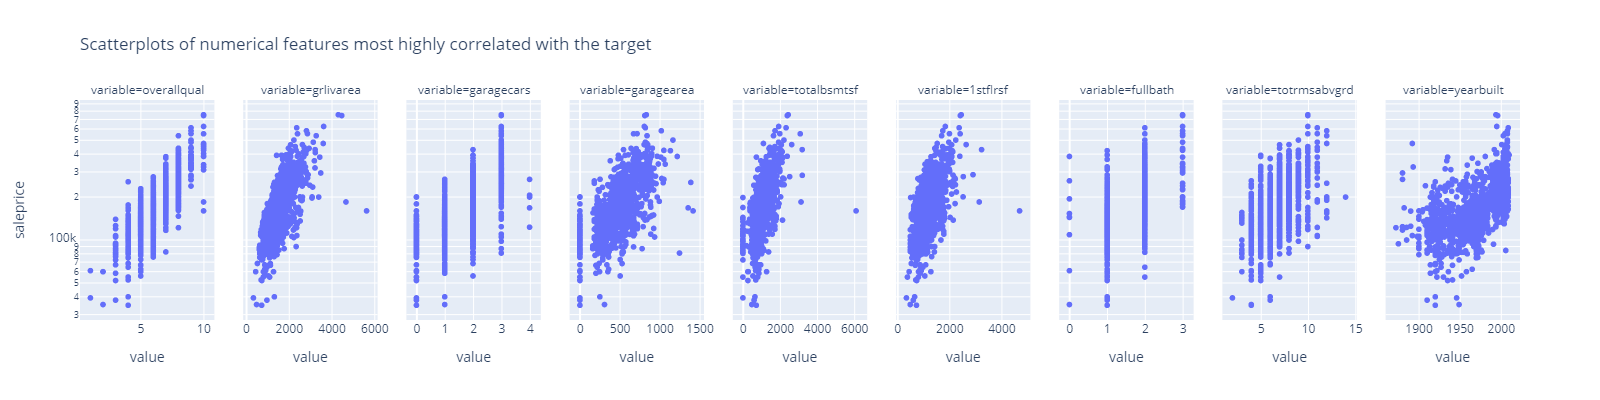

In [15]:
top_feat = og_train[['saleprice','overallqual','grlivarea','garagecars','garagearea','totalbsmtsf','1stflrsf','fullbath','totrmsabvgrd','yearbuilt']]
top_feat_long = top_feat.melt(id_vars='saleprice')

(px.scatter(top_feat_long, 
    x = 'value',
    y = 'saleprice',
    log_y= True,
    facet_col= 'variable',
    title = "Scatterplots of numerical features most highly correlated with the target",
    height = 400,
    width = 1600)
.update_xaxes(matches = None)
.show('png'))

## Split the data
Kaggle has already split the data into train and test but I still wwant a small holdout for final evaluation on my end (will use after crossvalidation)


In [16]:
def splitter(df, target, train_size, random_state):
    # Returns versions of test and train with and without the target for simple processing throughout the notebook
    train, test = train_test_split(df, train_size= train_size, random_state = random_state)

    X_train = train.drop(target, axis = 1).copy()
    y_train = train[target].copy()

    X_test = test.drop(target, axis = 1).copy()
    y_test = test[target].copy()

    return(train, test, X_train, X_test, y_train, y_test)

train, test, X_train, X_test, y_train, y_test = splitter(og_train, 'saleprice', train_size = .95, random_state = 324)


## Estimation

In [18]:
def reg_performance_readout(model, X_train, y_train, pred, cv_scores):
    print("R2 on taining set: ", r2_score(y_train, pred))
    print("MAPE on training set ", mean_absolute_percentage_error(y_train, pred))
    print("RMSE on training set ",mean_squared_error(y_train, pred,squared = False))
    print("Official Criterion: RMSLE on training set ", mean_squared_log_error(y_train, pred, squared = False))
    print("5 Fold Cross Val RMSLE Scores: ", cv_scores)

### Baseline Model 

In [50]:
cat_processor = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

num_processor = make_pipeline(
    SimpleImputer(strategy = 'median')
)

preprocessing = make_column_transformer(
    (cat_processor, make_column_selector(dtype_exclude = np.number)),
    (num_processor, make_column_selector(dtype_include= np.number))

)

baseline = make_pipeline(preprocessing, DummyRegressor())
baseline.fit(X_train, y_train)
base_pred = baseline.predict(X_train)
base_cv_rmsle = np.sqrt(-cross_val_score(baseline, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_log_error'))

reg_performance_readout(baseline, X_train, y_train, base_pred, base_cv_rmsle)

R2 on taining set:  0.0
MAPE on training set  0.36784519166735313
RMSE on training set  79762.64884852995
Official Criterion: RMSLE on training set  0.41100494716706554
5 Fold Cross Val RMSLE Scores:  [0.42504852 0.41650768 0.41357915 0.4222436  0.37679425]


In [113]:
# can use the below command to find list of metrics to specify via string in corss_val_score() under the scoring parameter
#sklearn.metrics.SCORERS.keys()

### Defining a simple data preprocessor

In [160]:
cat_processor = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

num_processor = make_pipeline(
    SimpleImputer(strategy = 'median'),
    StandardScaler()
)

preprocessing = make_column_transformer(
    (cat_processor, make_column_selector(dtype_exclude = np.number)),
    (num_processor, make_column_selector(dtype_include= np.number))
)



### Linear Regression 

In [20]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(X_train, y_train)
lin_pred = lin_reg.predict(X_train)
lin_cv_rmsle = np.sqrt(-cross_val_score(lin_reg, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_log_error'))

reg_performance_readout(lin_reg, X_train, y_train, lin_pred, lin_cv_rmsle)


c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
ValueError: Mean Squared Logarithmic Error cannot be used wh

R2 on taining set:  0.937389980913397
MAPE on training set  0.07640150979655821
RMSE on training set  19958.205322761693
Official Criterion: RMSLE on training set  0.10760265344498765
5 Fold Cross Val RMSLE Scores:  [0.20827944 0.15368461        nan 0.14268018        nan]


c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
ValueError: Mean Squared Logarithmic Error cannot be used wh

### Ridge Regression

In [21]:
from sklearn.linear_model import Ridge

ridge_reg = make_pipeline(preprocessing,Ridge())
ridge_reg.fit(X_train, y_train)
ridge_pred = ridge_reg.predict(X_train)
ridge_cv_rmsle = np.sqrt(-cross_val_score(ridge_reg, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_log_error'))

reg_performance_readout(ridge_reg, X_train, y_train, ridge_pred, ridge_cv_rmsle)


R2 on taining set:  0.9252113690208816
MAPE on training set  0.08254951432908665
RMSE on training set  21813.098466235468
Official Criterion: RMSLE on training set  0.114168975858916
5 Fold Cross Val RMSLE Scores:  [0.16230793 0.20323963 0.19646275 0.14785869 0.20264494]


### Lasso Regression

In [22]:
from sklearn.linear_model import Lasso

lasso_reg = make_pipeline(preprocessing, Lasso())
lasso_reg.fit(X_train, y_train)
lasso_pred = lasso_reg.predict(X_train)
lasso_cv_rmsle = np.sqrt(-cross_val_score(lasso_reg, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_log_error'))

reg_performance_readout(lasso_reg, X_train, y_train, lasso_pred, lasso_cv_rmsle)

c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5088265946.51709, tolerance: 882420516.9900112

c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 19074703972.73889, tolerance: 720101598.7739344

c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1479421426.8049316, tolerance: 697040017.3665899

c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterat

R2 on taining set:  0.9373486714518945
MAPE on training set  0.07656659223474675
RMSE on training set  19964.78834875543
Official Criterion: RMSLE on training set  0.10747171693302321
5 Fold Cross Val RMSLE Scores:  [0.18112501 0.14568324 0.24140522 0.14221656        nan]


c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8980709182.531433, tolerance: 733480936.3693485

c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._si

### Elastic Net

In [23]:
from sklearn.linear_model import ElasticNet

elasticnet_reg = make_pipeline(preprocessing, ElasticNet())
elasticnet_reg.fit(X_train, y_train)
elasticnet_pred = elasticnet_reg.predict(X_train)
elasticnet_cv_rmsle = np.sqrt(-cross_val_score(elasticnet_reg, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_log_error'))

reg_performance_readout(elasticnet_reg, X_train, y_train, elasticnet_pred, elasticnet_cv_rmsle)

R2 on taining set:  0.8332714419459317
MAPE on training set  0.10262758985654084
RMSE on training set  32569.010575335396
Official Criterion: RMSLE on training set  0.14062735313521188
5 Fold Cross Val RMSLE Scores:  [0.13546601 0.24760261 0.17130831 0.15307122 0.12570456]


### Random Forest

In [24]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = make_pipeline(preprocessing, RandomForestRegressor())
rf_reg.fit(X_train, y_train)
rf_pred = rf_reg.predict(X_train)
rf_cv_rmsle = np.sqrt(-cross_val_score(rf_reg, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_log_error'))

reg_performance_readout(rf_reg, X_train, y_train, rf_pred, rf_cv_rmsle)

R2 on taining set:  0.9817547943285797
MAPE on training set  0.038263386887706155
RMSE on training set  10773.925044251422
Official Criterion: RMSLE on training set  0.0586926782985175
5 Fold Cross Val RMSLE Scores:  [0.1437123  0.15366637 0.15821104 0.14309711 0.12290809]


### Gradient Boosted Regression Trees

In [25]:
from sklearn.ensemble import GradientBoostingRegressor

gb_reg = make_pipeline(preprocessing, GradientBoostingRegressor())
gb_reg.fit(X_train, y_train)
gb_pred = gb_reg.predict(X_train)
gb_cv_rmsle = np.sqrt(-cross_val_score(gb_reg, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_log_error'))

reg_performance_readout(gb_reg, X_train, y_train, gb_pred, gb_cv_rmsle)

R2 on taining set:  0.9699364693960654
MAPE on training set  0.06359094559199122
RMSE on training set  13829.916533888107
Official Criterion: RMSLE on training set  0.08549288068908327
5 Fold Cross Val RMSLE Scores:  [0.12783685 0.13334721 0.14930492 0.1415031  0.11261047]


### Histogram Based Gradient Boosted Regression Trees

In [26]:
from sklearn.ensemble import HistGradientBoostingRegressor

hgb_preprocessing = make_column_transformer(
    (
        OneHotEncoder(sparse = False, handle_unknown="ignore"),
        make_column_selector(dtype_include="category"),
    ),
    remainder="passthrough",
)

hgb_reg = make_pipeline(
    hgb_preprocessing, HistGradientBoostingRegressor(random_state=42)
)

hgb_reg.fit(X_train, y_train)
hgb_pred = hgb_reg.predict(X_train)
hgb_cv_rmsle = np.sqrt(-cross_val_score(hgb_reg, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_log_error'))

reg_performance_readout(hgb_reg, X_train, y_train, hgb_pred, hgb_cv_rmsle)

R2 on taining set:  0.9794784862620368
MAPE on training set  0.03318751838293031
RMSE on training set  11426.264272614284
Official Criterion: RMSLE on training set  0.054390882964741136
5 Fold Cross Val RMSLE Scores:  [0.13734615 0.14539419 0.14634424 0.12999027 0.12065818]


## Comparing performance across models
Notes: ensemble methods appear to outperform traditional regression models, additionaly GBRT appears much faster copmutationaly than RF of HGBRT

### Assessing cross validation RMSLE scores

In [49]:
cv_scores = pd.DataFrame({'linear':lin_cv_rmsle,
                    'ridge':ridge_cv_rmsle,
                    'lasso':lasso_cv_rmsle,
                    'elastic':elasticnet_cv_rmsle,
                    'rforest':rf_cv_rmsle,
                    'gradboost':gb_cv_rmsle,
                    'histgboost':hgb_cv_rmsle})

cv_scores.describe()

,linear,ridge,lasso,elastic,rforest,gradboost,histgboost
count,3.000000,5.000000,4.000000,5.000000,5.000000,5.000000,5.000000
mean,0.168215,0.182503,0.177608,0.166631,0.145179,0.132620,0.135947
std,0.035131,0.025684,0.046022,0.048498,0.013840,0.013626,0.010823
min,0.142680,0.147859,0.142217,0.125705,0.122172,0.112564,0.120658
25%,0.148182,0.162308,0.144817,0.135466,0.144662,0.129282,0.129990
50%,0.153685,0.196463,0.163404,0.153071,0.147231,0.131863,0.137346
75%,0.180982,0.202645,0.196195,0.171308,0.154945,0.140395,0.145394
max,0.208279,0.203240,0.241405,0.247603,0.156886,0.148998,0.146344


In [28]:
px.box(cv_scores.melt(var_name = 'model', value_name='RMSLE'),
    x = 'model',
    y = 'RMSLE',
    height = 600,
    width = 800,
    title = "Boxplots of model RMSLE scores across 5-Fold CV").show()

### Assessing model predictions and residuals

In [30]:
# Assmeble model predictions
model_predictions = pd.DataFrame({'linear':lin_pred,
                    'ridge':ridge_pred,
                    'lasso':lasso_pred,
                    'elastic':elasticnet_pred,
                    'rforest':rf_pred,
                    'gradboost':gb_pred,
                    'histgboost':hgb_pred})

# Attach model predictions to a copy of the training set called train_plus
train_plus = train.copy().reset_index(drop = True)
train_plus = pd.concat([train_plus,model_predictions], axis=1)


# Create a dataframe for simple scatterplots of target vs prediction as well as some of the top features
sc_df = (pd.concat([train_plus.loc[:,top_feat.columns.tolist()], train_plus.iloc[:,-7:]], axis = 1)
         .melt(id_vars=top_feat.columns.tolist(), var_name='model', value_name='prediction'))
sc_df['residual'] = sc_df['saleprice'] - sc_df['prediction'] 
sc_df['log_residual'] = np.log1p(sc_df['saleprice']) - np.log1p(sc_df['prediction'])
sc_df.head()


,saleprice,overallqual,grlivarea,garagecars,garagearea,totalbsmtsf,1stflrsf,fullbath,totrmsabvgrd,yearbuilt,model,prediction,residual,log_residual
0,175900,7,1569,3,660,1386,1569,2,7,2007,linear,206958.915981,-31058.915981,-0.162604
1,107400,3,1605,1,379,840,840,2,8,1915,linear,103436.876073,3963.123927,0.037598
2,98000,4,1529,1,240,0,1088,2,9,1945,linear,90720.099311,7279.900689,0.077188
3,213500,7,1797,2,639,939,939,2,8,2006,linear,204943.483769,8556.516231,0.040902
4,212000,8,1502,2,528,1488,1502,1,4,1985,linear,231417.407085,-19417.407085,-0.087636


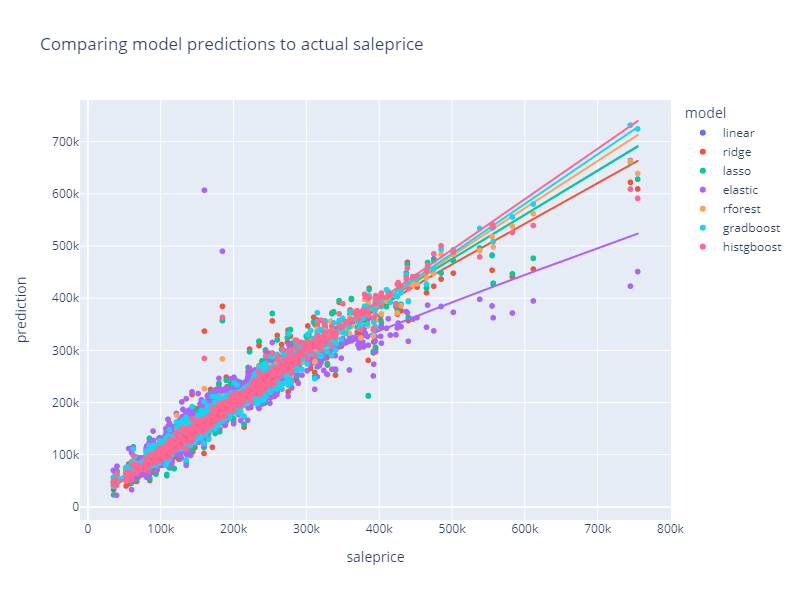

In [32]:
px.scatter(sc_df,
    x = 'saleprice',
    y = 'prediction',
    color = 'model',
    trendline='lowess',
    height = 600,
    width = 800,
    title = "Comparing model predictions to actual saleprice").show('png')

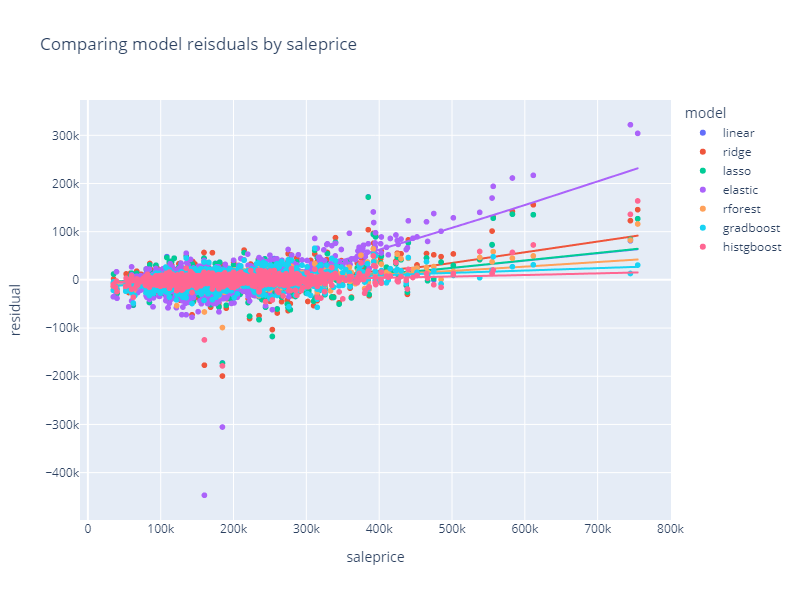

In [33]:
px.scatter(sc_df,
    x = 'saleprice',
    y = 'residual',
    color = 'model',
    trendline='lowess',
    height = 600,
    width = 800,
    title = 'Comparing model reisduals by saleprice').show('png')

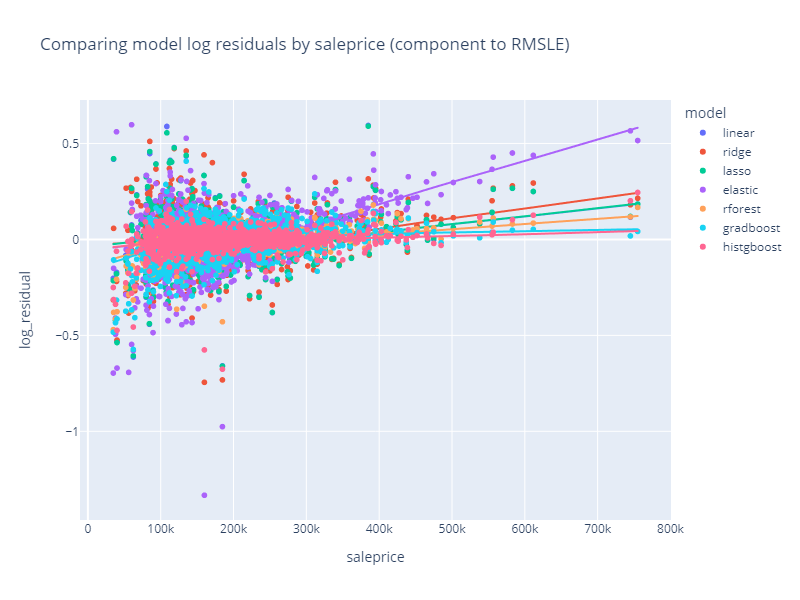

In [35]:
px.scatter(sc_df,
    x = 'saleprice',
    y = 'log_residual',
    color = 'model',
    trendline='lowess',
    height = 600,
    width = 800,
    title = 'Comparing model log residuals by saleprice (component to RMSLE)').show('png')

### Assessing performance by certain features

In [37]:
sc_df.head()

,saleprice,overallqual,grlivarea,garagecars,garagearea,totalbsmtsf,1stflrsf,fullbath,totrmsabvgrd,yearbuilt,model,prediction,residual,log_residual
0,175900,7,1569,3,660,1386,1569,2,7,2007,linear,206958.915981,-31058.915981,-0.162604
1,107400,3,1605,1,379,840,840,2,8,1915,linear,103436.876073,3963.123927,0.037598
2,98000,4,1529,1,240,0,1088,2,9,1945,linear,90720.099311,7279.900689,0.077188
3,213500,7,1797,2,639,939,939,2,8,2006,linear,204943.483769,8556.516231,0.040902
4,212000,8,1502,2,528,1488,1502,1,4,1985,linear,231417.407085,-19417.407085,-0.087636


In [38]:
sc_dfpl = sc_df.melt(id_vars=['model','prediction', 'residual', 'log_residual'], var_name='feature', value_name='value')
sc_dfpl.shape

(97090, 6)

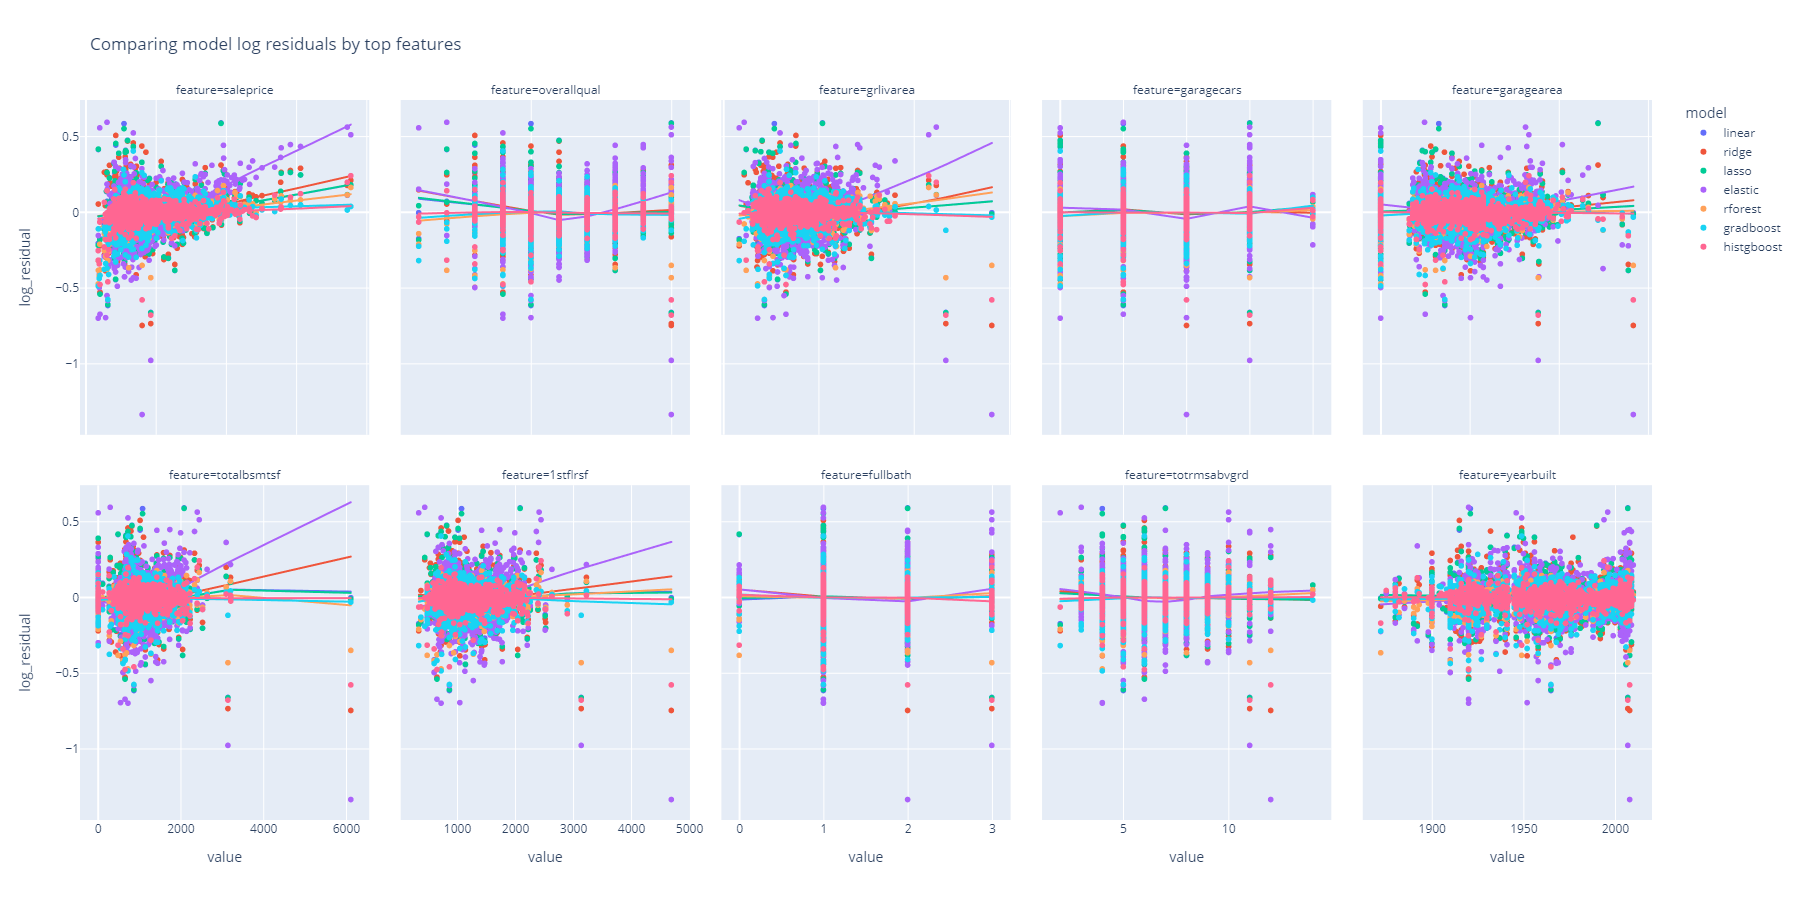

In [39]:
px.scatter(sc_dfpl,
        x = 'value',
        y = 'log_residual',
        color = 'model',
        trendline='lowess',
        facet_col= 'feature',
        facet_col_wrap= 5,
        height = 900,
        width = 1800,
        title = 'Comparing model log residuals by top features').update_xaxes(matches = None).show('png')

## Iterating

### Thinking about possible new feaures
- There are no features for the size of the house relative to the size of the lot, could try 1stflrsf / lotarea (1st floor sf as proxy for house sf footprint)
- Could also do size of garage relative to the size of the house above grade garagearea / grlivarea
- there are no features concerning the size of the yard, could do lot area - garagearea and 1stflrsf

Interactions between features?





In [40]:
train_2 = train.copy()
train_2['house_lot_prop'] = train_2['1stflrsf'] / train_2['lotarea']
train_2['garage_living_prop'] = train_2['garagearea'] / train_2['grlivarea']
train_2['yard_area'] = train_2['lotarea'] - train_2['1stflrsf'] - train_2['garagearea']

print("Correlations with target for the new features:")
print(train_2[['saleprice','house_lot_prop']].corr())
print(train_2[['saleprice','garage_living_prop']].corr())
print(train_2[['saleprice','yard_area']].corr())


Correlations with target for the new features:
                saleprice  house_lot_prop
saleprice        1.000000       -0.019731
house_lot_prop  -0.019731        1.000000
                    saleprice  garage_living_prop
saleprice             1.00000             0.09616
garage_living_prop    0.09616             1.00000
           saleprice  yard_area
saleprice   1.000000   0.221827
yard_area   0.221827   1.000000


### Adding in some new feaures and running the best candidate models

In [63]:
## Add in a couple features to X_train 
X_train_2 = X_train.copy()
X_train_2['garage_living_prop'] = X_train_2['garagearea'] / X_train_2['grlivarea']
X_train_2['yard_area'] = X_train_2['lotarea'] - X_train_2['1stflrsf'] - X_train_2['garagearea']

## Add in the same features to X_test to allow final evaluation
X_test_2 = X_test.copy()
X_test_2['garage_living_prop'] = X_test_2['garagearea'] / X_test_2['grlivarea']
X_test_2['yard_area'] = X_test_2['lotarea'] - X_test_2['1stflrsf'] - X_test_2['garagearea']

In [42]:
rf_reg2 = make_pipeline(preprocessing, RandomForestRegressor())
rf_reg2.fit(X_train_2, y_train)
rf_pred2 = rf_reg2.predict(X_train_2)
rf_cv_rmsle = np.sqrt(-cross_val_score(rf_reg2, X_train_2, y_train, cv = 5, scoring = 'neg_mean_squared_log_error'))

reg_performance_readout(rf_reg2, X_train_2, y_train, rf_pred2, rf_cv_rmsle)

R2 on taining set:  0.9788946909847863
MAPE on training set  0.03891572259379444
RMSE on training set  11587.651512427325
Official Criterion: RMSLE on training set  0.0610688511022937
5 Fold Cross Val RMSLE Scores:  [0.14466214 0.15494497 0.15688569 0.14723122 0.12217191]


In [78]:
gb_reg2 = make_pipeline(preprocessing, GradientBoostingRegressor())
gb_reg2.fit(X_train_2, y_train)
gbr2_pred = gb_reg2.predict(X_train_2)
gbr2_cv_rmsle = np.sqrt(-cross_val_score(gb_reg2, X_train_2, y_train, cv = 5, scoring = 'neg_mean_squared_log_error'))

reg_performance_readout(gb_reg2, X_train_2, y_train, gbr2_pred, gbr2_cv_rmsle)

R2 on taining set:  0.9700174298867581
MAPE on training set  0.0633589503963516
RMSE on training set  13811.282134669229
Official Criterion: RMSLE on training set  0.08617772181008837
5 Fold Cross Val RMSLE Scores:  [0.12904504 0.13332339 0.14967333 0.13998616 0.11247198]


In [79]:
hgb_reg2 = make_pipeline(
    hgb_preprocessing, HistGradientBoostingRegressor(random_state=42)
)

hgb_reg2.fit(X_train_2, y_train)
hgbr2_pred = hgb_reg2.predict(X_train_2)
hgbr2_cv_rmsle = np.sqrt(-cross_val_score(hgb_reg2, X_train_2, y_train, cv = 5, scoring = 'neg_mean_squared_log_error'))

reg_performance_readout(hgb_reg2, X_train_2, y_train, hgbr2_pred, hgbr2_cv_rmsle)


R2 on taining set:  0.9802950022724688
MAPE on training set  0.03243288601563485
RMSE on training set  11196.641234066852
Official Criterion: RMSLE on training set  0.05253779383432532
5 Fold Cross Val RMSLE Scores:  [0.14018418 0.14827202 0.14467925 0.12744265 0.11866286]


### Hyperparameter tuning the best models

In [44]:
#gb_reg2.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'gradientboostingregressor', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__verbose_feature_names_out', 'columntransformer__pipeline-1', 'columntransformer__pipeline-2', 'columntransformer__pipeline-1__memory', 'columntransformer__pipeline-1__steps', 'columntransformer__pipeline-1__verbose', 'columntransformer__pipeline-1__simpleimputer', 'columntransformer__pipeline-1__onehotencoder', 'columntransformer__pipeline-1__simpleimputer__add_indicator', 'columntransformer__pipeline-1__simpleimputer__copy', 'columntransformer__pipeline-1__simpleimputer__fill_value', 'columntransformer__pipeline-1__simpleimputer__missing_values', 'columntransformer__pipeline-1__simpleimputer__strategy', 'columntransformer__pipeline-1__simpleimputer__verbose', 'columntransf

In [70]:
gb_param_distribs = {'gradientboostingregressor__learning_rate':uniform(0, 2),
                    'gradientboostingregressor__n_estimators':randint(50, 250),
                    'gradientboostingregressor__min_samples_split':randint(2, 8),
                    'gradientboostingregressor__min_samples_leaf':randint(1, 4),
                    'gradientboostingregressor__max_depth':randint(2, 5)}

rnd_search  = RandomizedSearchCV(gb_reg2,
                                param_distributions=gb_param_distribs,
                                n_iter= 15,
                                cv = 5, 
                                scoring = 'neg_mean_squared_log_error', 
                                random_state=324)

rnd_search.fit(X_train_2, y_train)

print("Best hyperparameter combination:",rnd_search.best_params_)
rnd_search_results = pd.DataFrame(rnd_search.cv_results_)
rnd_search_results.sort_values(by = 'mean_test_score', ascending = False, inplace=True)
rnd_search_results

c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.


c:\Us

Best hyperparameter combination: {'gradientboostingregressor__learning_rate': 0.12063342713081471, 'gradientboostingregressor__max_depth': 2, 'gradientboostingregressor__min_samples_leaf': 1, 'gradientboostingregressor__min_samples_split': 2, 'gradientboostingregressor__n_estimators': 169}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gradientboostingregressor__learning_rate,param_gradientboostingregressor__max_depth,param_gradientboostingregressor__min_samples_leaf,param_gradientboostingregressor__min_samples_split,param_gradientboostingregressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.204789,0.117573,0.033822,0.010782,0.120633,2,1,2,169,{'gradientboostingregressor__learning_rate': 0...,-0.017757,-0.017672,-0.018463,-0.018236,-0.012396,-0.016905,0.002274,1
9,2.356663,0.074497,0.019963,0.001417,0.267002,4,3,2,193,{'gradientboostingregressor__learning_rate': 0...,-0.019873,-0.022272,-0.024357,-0.019913,-0.013931,-0.020069,0.003492,2
2,0.354451,0.012282,0.018928,0.000631,0.499212,2,3,4,51,{'gradientboostingregressor__learning_rate': 0...,-0.019139,-0.021306,-0.030390,-0.023082,-0.020664,-0.022916,0.003945,3
5,1.104991,0.032735,0.017757,0.000383,0.639938,2,3,6,179,{'gradientboostingregressor__learning_rate': 0...,-0.031357,-0.020769,-0.029957,-0.023330,-0.024743,-0.026031,0.004011,4
1,1.037105,0.038669,0.021755,0.001189,1.056344,2,2,3,163,{'gradientboostingregressor__learning_rate': 1...,-0.034366,-0.043264,-0.075008,-0.036589,-0.025943,-0.043034,0.016919,5
3,0.762299,0.109596,0.023561,0.009907,1.859939,3,1,5,66,{'gradientboostingregressor__learning_rate': 1...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
4,1.322666,0.025673,0.023379,0.005509,1.101485,4,3,5,98,{'gradientboostingregressor__learning_rate': 1...,-0.077135,-0.056190,NaN,-0.057235,NaN,NaN,NaN,7
6,1.413025,0.036137,0.020724,0.002300,1.05769,3,2,6,155,{'gradientboostingregressor__learning_rate': 1...,-0.047821,NaN,-0.068569,-0.039228,-0.047798,NaN,NaN,8
7,2.020859,0.143377,0.019178,0.001589,1.646943,3,2,6,201,{'gradientboostingregressor__learning_rate': 1...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
8,2.163790,0.034872,0.018754,0.000402,1.82402,3,3,7,230,{'gradientboostingregressor__learning_rate': 1...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10


In [71]:
gb_reg2_tuned = rnd_search.best_estimator_

gbr2t_pred = gb_reg2_tuned.predict(X_train_2)
gbr2t_cv_rmsle = np.sqrt(-cross_val_score(gb_reg, X_train_2, y_train, cv = 5, scoring = 'neg_mean_squared_log_error'))

reg_performance_readout(gb_reg2_tuned, X_train_2, y_train, gbr2t_pred, gbr2t_cv_rmsle)

R2 on taining set:  0.961892282352854
MAPE on training set  0.0700367531552315
RMSE on training set  15570.624716290104
Official Criterion: RMSLE on training set  0.09468170041601467
5 Fold Cross Val RMSLE Scores:  [0.12891522 0.13479976 0.14997534 0.1401647  0.11213483]


In [67]:
hgb_reg2.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'histgradientboostingregressor', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__verbose_feature_names_out', 'columntransformer__onehotencoder', 'columntransformer__onehotencoder__categories', 'columntransformer__onehotencoder__drop', 'columntransformer__onehotencoder__dtype', 'columntransformer__onehotencoder__handle_unknown', 'columntransformer__onehotencoder__sparse', 'histgradientboostingregressor__categorical_features', 'histgradientboostingregressor__early_stopping', 'histgradientboostingregressor__l2_regularization', 'histgradientboostingregressor__learning_rate', 'histgradientboostingregressor__loss', 'histgradientboostingregressor__max_bins', 'histgradientboostingregressor__max_depth', 'histgradientboostingregressor__max_iter', 'histgradien

In [72]:
hgb_param_distribs = {'histgradientboostingregressor__learning_rate':uniform(0, 2),
                    'histgradientboostingregressor__max_iter':randint(50, 250),
                    'histgradientboostingregressor__min_samples_leaf':randint(1, 4),
                    'histgradientboostingregressor__max_depth':randint(2, 5)}

rnd_search  = RandomizedSearchCV(hgb_reg2,
                                param_distributions=hgb_param_distribs,
                                n_iter= 15,
                                cv = 5, 
                                scoring = 'neg_mean_squared_log_error', 
                                random_state=324)

rnd_search.fit(X_train_2, y_train)

print("Best hyperparameter combination:",rnd_search.best_params_)
rnd_search_results = pd.DataFrame(rnd_search.cv_results_)
rnd_search_results.sort_values(by = 'mean_test_score', ascending = False, inplace=True)
rnd_search_results

c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.


c:\Us

Best hyperparameter combination: {'histgradientboostingregressor__learning_rate': 0.12473554207153947, 'histgradientboostingregressor__max_depth': 2, 'histgradientboostingregressor__max_iter': 191, 'histgradientboostingregressor__min_samples_leaf': 2}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_histgradientboostingregressor__learning_rate,param_histgradientboostingregressor__max_depth,param_histgradientboostingregressor__max_iter,param_histgradientboostingregressor__min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,1.686017,0.301411,0.057846,0.021309,0.124736,2,191,2,{'histgradientboostingregressor__learning_rate...,-0.017538,-0.016985,-0.023206,-0.017435,-0.011921,-0.017417,0.003575,1
0,0.942368,0.050709,0.041091,0.001597,0.120633,2,138,1,{'histgradientboostingregressor__learning_rate...,-0.018896,-0.018560,-0.021140,-0.019014,-0.012524,-0.018027,0.002898,2
2,1.979159,0.073735,0.043880,0.002749,0.487484,3,163,3,{'histgradientboostingregressor__learning_rate...,-0.025992,-0.024563,-0.030833,-0.020490,-0.018026,-0.023980,0.004449,3
1,0.684207,0.026634,0.044186,0.006004,0.671761,2,90,1,{'histgradientboostingregressor__learning_rate...,-0.037364,-0.024775,-0.036664,-0.022519,-0.025902,-0.029445,0.006279,4
3,6.540281,2.159860,0.094546,0.050623,0.680569,4,164,2,{'histgradientboostingregressor__learning_rate...,-0.030187,-0.032544,-0.034217,-0.025059,-0.027935,-0.029989,0.003255,5
5,1.847560,0.577053,0.070214,0.039843,0.988036,2,199,3,{'histgradientboostingregressor__learning_rate...,-0.038612,-0.029875,-0.043973,-0.030209,-0.028467,-0.034227,0.006041,6
8,2.041485,0.163492,0.076049,0.032998,0.848618,4,57,1,{'histgradientboostingregressor__learning_rate...,-0.045692,-0.039856,-0.058649,-0.036561,-0.055767,-0.047305,0.008647,7
4,1.855019,0.673378,0.057170,0.029677,1.859939,3,66,3,{'histgradientboostingregressor__learning_rate...,NaN,-0.188174,NaN,-0.115595,NaN,NaN,NaN,8
6,1.847529,0.428852,0.128567,0.115665,1.664035,2,204,1,{'histgradientboostingregressor__learning_rate...,NaN,-0.177375,NaN,NaN,NaN,NaN,NaN,9
9,3.032267,0.816400,0.080403,0.029554,0.913191,3,124,2,{'histgradientboostingregressor__learning_rate...,-0.050010,NaN,-0.044901,-0.032679,-0.041075,NaN,NaN,10


In [73]:
hgb_reg2_tuned = rnd_search.best_estimator_

hgbr2t_pred = hgb_reg2_tuned.predict(X_train_2)
hgbr2t_cv_rmsle = np.sqrt(-cross_val_score(hgb_reg, X_train_2, y_train, cv = 5, scoring = 'neg_mean_squared_log_error'))

reg_performance_readout(hgb_reg2_tuned, X_train_2, y_train, hgbr2t_pred, hgbr2t_cv_rmsle)

R2 on taining set:  0.9644632202113042
MAPE on training set  0.06622528328472285
RMSE on training set  15036.217653917669
Official Criterion: RMSLE on training set  0.08998075498956137
5 Fold Cross Val RMSLE Scores:  [0.14018418 0.14827202 0.14467925 0.12744265 0.11866286]


### Refining the preprocessor

In [162]:
cat_processor_plus = make_pipeline(
    KNNImputer(),
    OneHotEncoder(handle_unknown='ignore')
)

num_processor_plus = make_pipeline(
    KNNImputer(),
    RobustScaler()
)

preprocessing_plus = make_column_transformer(
    (cat_processor_plus, make_column_selector(dtype_exclude = np.number)),
    (num_processor_plus, make_column_selector(dtype_include= np.number))
)


In [163]:
gb_reg2_plus = make_pipeline(preprocessing, GradientBoostingRegressor())
gb_reg2_plus.fit(X_train_2, y_train)
gbr2p_pred = gb_reg2.predict(X_train_2)
gbr2p_cv_rmsle = np.sqrt(-cross_val_score(gb_reg2, X_train_2, y_train, cv = 5, scoring = 'neg_mean_squared_log_error'))

reg_performance_readout(gb_reg2_plus, X_train_2, y_train, gbr2p_pred, gbr2p_cv_rmsle)

R2 on taining set:  0.9700174298867581
MAPE on training set  0.0633589503963516
RMSE on training set  13811.282134669229
Official Criterion: RMSLE on training set  0.08617772181008837
5 Fold Cross Val RMSLE Scores:  [0.12920914 0.13500177 0.15005663 0.1418062  0.11295568]


### Removing Outliers from the training set
Put a cap on sale price for the model to be trained upon but still validate using entire training set. NOte the corss validation will take place on the reduced train set which will nec make the model look better

In [100]:
train_2['saleprice'].describe(percentiles = [.75,.9,.95,.99])

count      1387.000000
mean     181384.666907
std       79791.418065
min       34900.000000
50%      163500.000000
75%      214700.000000
90%      280000.000000
95%      328630.000000
99%      440876.540000
max      755000.000000
Name: saleprice, dtype: float64

In [124]:
#y_train.index.equals(X_train_2.index)

threshold = np.percentile(y_train, 99)

y_train_filtered = y_train[y_train < threshold]
X_train_2_filtered = X_train_2.filter(items = y_train_filtered.index, axis = 0)

# Assess whether indices of x tain and y train are still the same
y_train_filtered.index.equals(X_train_2_filtered.index)


In [125]:
y_train_filtered.index.equals(X_train_2_filtered.index)

True

In [127]:
gb_reg2_f = make_pipeline(preprocessing, GradientBoostingRegressor())
gb_reg2_f.fit(X_train_2_filtered, y_train_filtered)
gbr2f_pred = gb_reg2.predict(X_train_2_filtered)
gbr2f_cv_rmsle = np.sqrt(-cross_val_score(gb_reg2, X_train_2_filtered, y_train_filtered, cv = 5, scoring = 'neg_mean_squared_log_error'))

reg_performance_readout(gb_reg2, X_train_2_filtered, y_train_filtered, gbr2f_pred, gbr2f_cv_rmsle)

R2 on taining set:  0.9624521367744877
MAPE on training set  0.0636301515162384
RMSE on training set  13655.322133214044
Official Criterion: RMSLE on training set  0.08648786090645552
5 Fold Cross Val RMSLE Scores:  [0.13135341 0.12642167 0.13321139 0.13502888 0.11130237]


### Last Look at model performance via CV

In [164]:
cv_scores['gb_2'] = gbr2_cv_rmsle
cv_scores['hgb_2'] = hgbr2_cv_rmsle
cv_scores['tuned_gb_2'] = gbr2t_cv_rmsle
cv_scores['tuned_hgb_2'] = hgbr2t_cv_rmsle
cv_scores['gb_2_plus'] = gbr2p_cv_rmsle
cv_scores['gb_2_f'] = gbr2f_cv_rmsle

cv_scores

,linear,ridge,lasso,elastic,rforest,gradboost,histgboost,tuned_gb_2,tuned_hgb_2,gb_2,hgb_2,gb_2_f,gb_2_plus
0,0.208279,0.162308,0.181125,0.135466,0.144662,0.129282,0.137346,0.128915,0.140184,0.129045,0.140184,0.131353,0.129209
1,0.153685,0.203240,0.145683,0.247603,0.154945,0.131863,0.145394,0.134800,0.148272,0.133323,0.148272,0.126422,0.135002
2,NaN,0.196463,0.241405,0.171308,0.156886,0.148998,0.146344,0.149975,0.144679,0.149673,0.144679,0.133211,0.150057
3,0.142680,0.147859,0.142217,0.153071,0.147231,0.140395,0.129990,0.140165,0.127443,0.139986,0.127443,0.135029,0.141806
4,NaN,0.202645,NaN,0.125705,0.122172,0.112564,0.120658,0.112135,0.118663,0.112472,0.118663,0.111302,0.112956


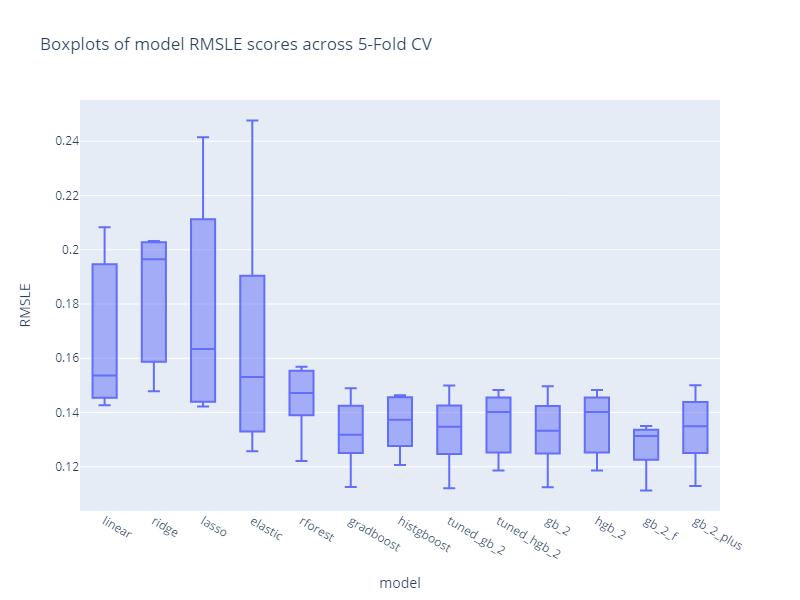

In [170]:
px.box(cv_scores.melt(var_name = 'model', value_name='RMSLE'),
    x = 'model',
    y = 'RMSLE',
    height = 600,
    width = 800,
    title = "Boxplots of model RMSLE scores across 5-Fold CV").show('png')

## Evaluating models on tiny test set
Which model does the best on our 5% holdout?

In [167]:
print("GBR2 Filtered RMSLE:", mean_squared_log_error(y_test, gb_reg2_f.predict(X_test_2), squared = False))

print("GBR2 RMSLE:", mean_squared_log_error(y_test, gb_reg2.predict(X_test_2), squared = False))

print("GBR Tuned RMSLE:", mean_squared_log_error(y_test, gb_reg2_tuned.predict(X_test_2), squared = False))

print("GBR Plus RMSLE:", mean_squared_log_error(y_test, gb_reg2_plus.predict(X_test_2), squared = False))


GBR2 Filtered RMSLE: 0.1646320877707861
GBR2 RMSLE: 0.14681418429486578
GBR Tuned RMSLE: 0.14828363282440007
GBR Plus RMSLE: 0.14686149077293156


## Prepping Kaggle Submission
Official test data is stored in variable og_test

In [87]:
og_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


### Perform Initial data prep and transformations same as on og_train

In [89]:
# Fill na in object cols with 'not_applicable before converting to category
og_test[object_cols] = og_test[object_cols].fillna(value = 'not_applicable')
og_test[object_cols] = og_test[object_cols].astype('category')
og_test.columns = og_test.columns.str.lower()


### Add in new features

In [90]:
og_test_2 = og_test.copy()
og_test_2['garage_living_prop'] = og_test_2['garagearea'] / og_test_2['grlivarea']
og_test_2['yard_area'] = og_test_2['lotarea'] - og_test_2['1stflrsf'] - og_test_2['garagearea']

### Make Predictions

In [168]:
og_test_pred_gbr2 = gb_reg2.predict(og_test_2)

og_test_pred_gbr2_f = gb_reg2_f.predict(og_test_2)

og_test_pred_gbr2_p = gb_reg2_plus.predict(og_test_2)



### Format in the way Kaggle permits

In [157]:
def generate_submission(predictions):
        submission = og_test_2.copy()
        submission['SalePrice'] = predictions
        submission = submission[['id','SalePrice']]
        return(submission)

In [158]:
gbr2_sub = generate_submission(predictions = og_test_pred_gbr2)
gbr2f_sub = generate_submission(predictions = og_test_pred_gbr2_f)
gbr2p_sub = generate_submission(predictions = og_test_pred_gbr2_p)

In [169]:
gbr2_sub.to_csv(path_or_buf = 'c:\\Users\\parke\\data_work\\datascience\\machine_learning\\house_prices\\gbr2_sub.csv', index = False)
gbr2f_sub.to_csv(path_or_buf = 'c:\\Users\\parke\\data_work\\datascience\\machine_learning\\house_prices\\gbr2f_sub.csv', index = False)
gbr2f_sub.to_csv(path_or_buf = 'c:\\Users\\parke\\data_work\\datascience\\machine_learning\\house_prices\\gbr2p_sub.csv', index = False)